### Theory

https://towardsdatascience.com/deriving-the-backpropagation-equations-from-scratch-part-2-693d4162e779
https://dustinstansbury.github.io/theclevermachine/derivation-backpropagation
http://neuralnetworksanddeeplearning.com/chap2.html
https://github.com/nndl-solutions/NNDL-solutions

https://www.jasonosajima.com/backprop - Detailed

### Implementations

https://github.com/jaymody/backpropagation - Multiclass Classification

https://mlfromscratch.com/neural-network-tutorial/#/ - MNIST
https://github.com/Vercaca/NN-Backpropagation - XOR
https://medium.com/analytics-vidhya/coding-a-neural-network-for-xor-logic-classifier-from-scratch-b90543648e8a - Basic


In [ ]:
## https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/

In [ ]:
# https://blog.zhaytam.com/2018/08/15/implement-neural-network-backpropagation/

import numpy as np

np.random.seed(100)


class Layer:
    """
    Represents a layer (hidden or output) in our neural network.
    """

    def __init__(self, n_input, n_neurons, activation=None, weights=None, bias=None):
        """
        :param int n_input: The input size (coming from the input layer or a previous hidden layer)
        :param int n_neurons: The number of neurons in this layer.
        :param str activation: The activation function to use (if any).
        :param weights: The layer's weights.
        :param bias: The layer's bias.
        """

        self.weights = weights if weights is not None else np.random.rand(n_input, n_neurons)
        self.activation = activation
        self.bias = bias if bias is not None else np.random.rand(n_neurons)
        self.last_activation = None
        self.error = None
        self.delta = None

    def activate(self, x):
        """
        Calculates the dot product of this layer.
        :param x: The input.
        :return: The result.
        """

        r = np.dot(x, self.weights) + self.bias
        self.last_activation = self._apply_activation(r)
        return self.last_activation

    def _apply_activation(self, r):
        """
        Applies the chosen activation function (if any).
        :param r: The normal value.
        :return: The "activated" value.
        """

        # In case no activation function was chosen
        if self.activation is None:
            return r

        # tanh
        if self.activation == 'tanh':
            return np.tanh(r)

        # sigmoid
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-r))

        return r

    def apply_activation_derivative(self, r):
        """
        Applies the derivative of the activation function (if any).
        :param r: The normal value.
        :return: The "derived" value.
        """

        # We use 'r' directly here because its already activated, the only values that
        # are used in this function are the last activations that were saved.

        if self.activation is None:
            return r

        if self.activation == 'tanh':
            return 1 - r ** 2

        if self.activation == 'sigmoid':
            return r * (1 - r)

        return r


class NeuralNetwork:
    """
    Represents a neural network.
    """

    def __init__(self):
        self._layers = []

    def add_layer(self, layer):
        """
        Adds a layer to the neural network.
        :param Layer layer: The layer to add.
        """

        self._layers.append(layer)

    def feed_forward(self, X):
        """
        Feed forward the input through the layers.
        :param X: The input values.
        :return: The result.
        """

        for layer in self._layers:
            X = layer.activate(X)

        return X

    def predict(self, X):
        """
        Predicts a class (or classes).
        :param X: The input values.
        :return: The predictions.
        """

        ff = self.feed_forward(X)

        # One row
        if ff.ndim == 1:
            return np.argmax(ff)

        # Multiple rows
        return np.argmax(ff, axis=1)

    def backpropagation(self, X, y, learning_rate):
        """
        Performs the backward propagation algorithm and updates the layers weights.
        :param X: The input values.
        :param y: The target values.
        :param float learning_rate: The learning rate (between 0 and 1).
        """

        # Feed forward for the output
        output = self.feed_forward(X)

        # Loop over the layers backward
        for i in reversed(range(len(self._layers))):
            layer = self._layers[i]

            # If this is the output layer
            if layer == self._layers[-1]:
                layer.error = y - output
                # The output = layer.last_activation in this case
                layer.delta = layer.error * layer.apply_activation_derivative(output)
            else:
                next_layer = self._layers[i + 1]
                layer.error = np.dot(next_layer.weights, next_layer.delta)
                layer.delta = layer.error * layer.apply_activation_derivative(layer.last_activation)

        # Update the weights
        for i in range(len(self._layers)):
            layer = self._layers[i]
            # The input is either the previous layers output or X itself (for the first hidden layer)
            input_to_use = np.atleast_2d(X if i == 0 else self._layers[i - 1].last_activation)
            layer.weights += layer.delta * input_to_use.T * learning_rate

    def train(self, X, y, learning_rate, max_epochs):
        """
        Trains the neural network using backpropagation.
        :param X: The input values.
        :param y: The target values.
        :param float learning_rate: The learning rate (between 0 and 1).
        :param int max_epochs: The maximum number of epochs (cycles).
        :return: The list of calculated MSE errors.
        """

        mses = []

        for i in range(max_epochs):
            for j in range(len(X)):
                self.backpropagation(X[j], y[j], learning_rate)
            if i % 10 == 0:
                mse = np.mean(np.square(y - nn.feed_forward(X)))
                mses.append(mse)
                print('Epoch: #%s, MSE: %f' % (i, float(mse)))

        return mses

    @staticmethod
    def accuracy(y_pred, y_true):
        """
        Calculates the accuracy between the predicted labels and true labels.
        :param y_pred: The predicted labels.
        :param y_true: The true labels.
        :return: The calculated accuracy.
        """

        return (y_pred == y_true).mean()
Training the neural network to solve the Binary AND problem
nn = NeuralNetwork()
nn.add_layer(Layer(2, 3, 'tanh'))
nn.add_layer(Layer(3, 3, 'sigmoid'))
nn.add_layer(Layer(3, 2, 'sigmoid'))

# Define dataset
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [0], [0], [1]])

# Train the neural network
errors = nn.train(X, y, 0.3, 290)
print('Accuracy: %.2f%%' % (nn.accuracy(nn.predict(X), y.flatten()) * 100))

# Plot changes in mse
plt.plot(errors)
plt.title('Changes in MSE')
plt.xlabel('Epoch (every 10th)')
plt.ylabel('MSE')
plt.show()

loss = 22.132247686866258
loss = 22.132233167584015
loss = 22.132218632185904
loss = 22.13220408058039
loss = 22.13218951267573
loss = 22.132174928379925
loss = 22.13216032760075
loss = 22.13214571024574
loss = 22.132131076222198
loss = 22.13211642543718
loss = 22.132101757797503
loss = 22.13208707320973
loss = 22.132072371580186
loss = 22.132057652814954
loss = 22.13204291681985
loss = 22.13202816350044
loss = 22.132013392762055
loss = 22.131998604509743
loss = 22.13198379864831
loss = 22.131968975082298
loss = 22.131954133715986
loss = 22.13193927445338
loss = 22.131924397198237
loss = 22.131909501854025
loss = 22.131894588323956
loss = 22.131879656510964
loss = 22.131864706317703
loss = 22.131849737646565
loss = 22.131834750399637
loss = 22.13181974447875
loss = 22.13180471978544
loss = 22.131789676220954
loss = 22.131774613686265
loss = 22.131759532082036
loss = 22.131744431308654
loss = 22.13172931126621
loss = 22.131714171854487
loss = 22.13169901297298
loss = 22.13168383452088
l

loss = 22.125952222604898
loss = 22.125924960726618
loss = 22.125897621987445
loss = 22.125870206002002
loss = 22.12584271238254
loss = 22.125815140738922
loss = 22.12578749067861
loss = 22.12575976180665
loss = 22.125731953725623
loss = 22.125704066035674
loss = 22.12567609833445
loss = 22.1256480502171
loss = 22.125619921276254
loss = 22.125591711102
loss = 22.12556341928186
loss = 22.12553504540077
loss = 22.12550658904107
loss = 22.125478049782465
loss = 22.12544942720202
loss = 22.12542072087414
loss = 22.125391930370515
loss = 22.125363055260156
loss = 22.125334095109313
loss = 22.125305049481486
loss = 22.125275917937415
loss = 22.125246700035017
loss = 22.125217395329393
loss = 22.1251880033728
loss = 22.12515852371461
loss = 22.12512895590132
loss = 22.125099299476503
loss = 22.125069553980772
loss = 22.125039718951797
loss = 22.125009793924246
loss = 22.12497977842977
loss = 22.12494967199698
loss = 22.124919474151415
loss = 22.124889184415537
loss = 22.12485880230867
loss = 

loss = 22.108464733365658
loss = 22.1083567646621
loss = 22.10824811200881
loss = 22.108138768841116
loss = 22.108028728511005
loss = 22.107917984285773
loss = 22.10780652934669
loss = 22.10769435678762
loss = 22.107581459613634
loss = 22.10746783073959
loss = 22.10735346298866
loss = 22.107238349090867
loss = 22.107122481681593
loss = 22.107005853300006
loss = 22.10688845638751
loss = 22.106770283286167
loss = 22.10665132623703
loss = 22.106531577378522
loss = 22.1064110287447
loss = 22.10628967226357
loss = 22.1061674997553
loss = 22.10604450293044
loss = 22.105920673388066
loss = 22.105796002613932
loss = 22.105670481978564
loss = 22.105544102735315
loss = 22.10541685601836
loss = 22.105288732840698
loss = 22.105159724092083
loss = 22.105029820536895
loss = 22.104899012812027
loss = 22.10476729142465
loss = 22.104634646750007
loss = 22.104501069029094
loss = 22.10436654836637
loss = 22.104231074727327
loss = 22.104094637936093
loss = 22.103957227672932
loss = 22.103818833471713
loss

loss = 21.230337750243024
loss = 21.193439936908366
loss = 21.155249937986916
loss = 21.11584689563784
loss = 21.075329105929875
loss = 21.033812347216884
loss = 20.991427018459447
loss = 20.9483141552854
loss = 20.904620547224578
loss = 20.860493332986277
loss = 20.816074568210723
loss = 20.77149630870477
loss = 20.72687670999124
loss = 20.682317510119947
loss = 20.637903060675654
loss = 20.593700843932055
loss = 20.549763212278567
loss = 20.506129950970628
loss = 20.462831217847924
loss = 20.419890450227374
loss = 20.377326926236456
loss = 20.335157792620844
loss = 20.293399492517327
loss = 20.252068623212132
loss = 20.2111823158918
loss = 20.170758257566987
loss = 20.130814476903783
loss = 20.09136900021424
loss = 20.05243946028442
loss = 20.014042715779837
loss = 19.976194516792358
loss = 19.938909234578254
loss = 19.902199661020052
loss = 19.866076875263392
loss = 19.830550170392073
loss = 19.79562703091905
loss = 19.76131315142661
loss = 19.727612487216177
loss = 19.6945273288537

loss = 17.454068479499863
loss = 17.45122942793782
loss = 17.44839729283754
loss = 17.44557204985033
loss = 17.44275367497985
loss = 17.439942144573372
loss = 17.437137435313193
loss = 17.434339524208244
loss = 17.431548388585846
loss = 17.42876400608363
loss = 17.42598635464165
loss = 17.42321541249462
loss = 17.420451158164315
loss = 17.41769357045214
loss = 17.41494262843186
loss = 17.412198311442438
loss = 17.40946059908106
loss = 17.40672947119631
loss = 17.404004907881447
loss = 17.40128688946784
loss = 17.3985753965186
loss = 17.395870409822233
loss = 17.393171910386528
loss = 17.390479879432533
loss = 17.387794298388684
loss = 17.385115148885006
loss = 17.382442412747526
loss = 17.37977607199274
loss = 17.377116108822236
loss = 17.374462505617416
loss = 17.37181524493436
loss = 17.369174309498796
loss = 17.366539682201164
loss = 17.363911346091832
loss = 17.361289284376394
loss = 17.358673480411063
loss = 17.356063917698236
loss = 17.35346057988208
loss = 17.350863450744274
los

loss = 16.803460430817967
loss = 16.802142170977607
loss = 16.80082672565865
loss = 16.79951408666144
loss = 16.798204245812055
loss = 16.79689719496224
loss = 16.79559292598937
loss = 16.794291430796402
loss = 16.79299270131183
loss = 16.791696729489644
loss = 16.790403507309264
loss = 16.78911302677551
loss = 16.787825279918543
loss = 16.786540258793817
loss = 16.785257955482027
loss = 16.783978362089073
loss = 16.782701470745973
loss = 16.781427273608863
loss = 16.78015576285889
loss = 16.77888693070221
loss = 16.777620769369893
loss = 16.776357271117906
loss = 16.775096428227016
loss = 16.773838233002785
loss = 16.772582677775482
loss = 16.77132975490004
loss = 16.770079456755987
loss = 16.768831775747408
loss = 16.767586704302893
loss = 16.766344234875447
loss = 16.765104359942477
loss = 16.76386707200569
loss = 16.76263236359109
loss = 16.76140022724886
loss = 16.760170655553345
loss = 16.75894364110298
loss = 16.75771917652024
loss = 16.75649725445156
loss = 16.75527786756729
lo

loss = 16.4817776014222
loss = 16.48106967451636
loss = 16.480362901850107
loss = 16.47965728065165
loss = 16.478952808157814
loss = 16.478249481614
loss = 16.477547298274178
loss = 16.47684625540084
loss = 16.476146350264973
loss = 16.475447580146028
loss = 16.47474994233189
loss = 16.474053434118847
loss = 16.47335805281156
loss = 16.472663795723022
loss = 16.471970660174566
loss = 16.47127864349578
loss = 16.470587743024513
loss = 16.46989795610684
loss = 16.469209280097033
loss = 16.468521712357514
loss = 16.467835250258855
loss = 16.467149891179716
loss = 16.46646563250685
loss = 16.46578247163504
loss = 16.465100405967107
loss = 16.464419432913843
loss = 16.463739549893997
loss = 16.463060754334272
loss = 16.462383043669252
loss = 16.461706415341407
loss = 16.46103086680105
loss = 16.460356395506306
loss = 16.459682998923103
loss = 16.459010674525118
loss = 16.458339419793763
loss = 16.45766923221817
loss = 16.457000109295134
loss = 16.45633204852911
loss = 16.45566504743217
loss

loss = 16.297300434779498
loss = 16.29686267388765
loss = 16.2964254806429
loss = 16.29598885396394
loss = 16.295552792772266
loss = 16.29511729599214
loss = 16.29468236255058
loss = 16.294247991377368
loss = 16.293814181405036
loss = 16.293380931568848
loss = 16.292948240806812
loss = 16.29251610805964
loss = 16.292084532270767
loss = 16.29165351238634
loss = 16.29122304735518
loss = 16.290793136128826
loss = 16.29036377766147
loss = 16.289934970909986
loss = 16.28950671483391
loss = 16.28907900839543
loss = 16.288651850559386
loss = 16.288225240293247
loss = 16.287799176567116
loss = 16.28737365835371
loss = 16.286948684628378
loss = 16.286524254369045
loss = 16.28610036655626
loss = 16.285677020173136
loss = 16.285254214205384
loss = 16.28483194764128
loss = 16.284410219471663
loss = 16.283989028689934
loss = 16.283568374292027
loss = 16.28314825527644
loss = 16.28272867064418
loss = 16.28230961939879
loss = 16.281891100546332
loss = 16.281473113095366
loss = 16.28105565605696
loss 

loss = 16.181033427975958
loss = 16.180734447633743
loss = 16.18043579371969
loss = 16.18013746572497
loss = 16.17983946314183
loss = 16.179541785463595
loss = 16.17924443218468
loss = 16.178947402800578
loss = 16.178650696807836
loss = 16.178354313704087
loss = 16.17805825298803
loss = 16.177762514159426
loss = 16.17746709671909
loss = 16.177172000168913
loss = 16.176877224011825
loss = 16.176582767751814
loss = 16.176288630893925
loss = 16.175994812944243
loss = 16.175701313409892
loss = 16.17540813179905
loss = 16.175115267620935
loss = 16.17482272038578
loss = 16.17453048960488
loss = 16.174238574790532
loss = 16.173946975456087
loss = 16.1736556911159
loss = 16.173364721285363
loss = 16.173074065480876
loss = 16.17278372321987
loss = 16.172493694020762
loss = 16.17220397740302
loss = 16.171914572887086
loss = 16.171625479994425
loss = 16.17133669824751
loss = 16.17104822716979
loss = 16.170760066285744
loss = 16.17047221512082
loss = 16.170184673201472
loss = 16.16989744005514
los

loss = 16.099664586473594
loss = 16.099448913543398
loss = 16.099233446935287
loss = 16.099018186376636
loss = 16.098803131595332
loss = 16.098588282319728
loss = 16.098373638278662
loss = 16.09815919920147
loss = 16.09794496481794
loss = 16.09773093485837
loss = 16.097517109053502
loss = 16.097303487134578
loss = 16.09709006883331
loss = 16.09687685388188
loss = 16.096663842012955
loss = 16.096451032959656
loss = 16.096238426455592
loss = 16.09602602223483
loss = 16.095813820031914
loss = 16.095601819581848
loss = 16.095390020620112
loss = 16.095178422882643
loss = 16.094967026105852
loss = 16.094755830026603
loss = 16.09454483438223
loss = 16.09433403891052
loss = 16.094123443349734
loss = 16.09391304743858
loss = 16.09370285091623
loss = 16.093492853522307
loss = 16.0932830549969
loss = 16.093073455080543
loss = 16.09286405351423
loss = 16.09265485003941
loss = 16.092445844397975
loss = 16.092237036332275
loss = 16.09202842558511
loss = 16.091820011899724
loss = 16.09161179501981
lo

loss = 16.0344769880457
loss = 16.034320265307045
loss = 16.03416367603739
loss = 16.03400722008311
loss = 16.033850897290804
loss = 16.0336947075073
loss = 16.033538650579647
loss = 16.033382726355125
loss = 16.033226934681235
loss = 16.033071275405707
loss = 16.03291574837649
loss = 16.03276035344176
loss = 16.032605090449916
loss = 16.03244995924958
loss = 16.032294959689594
loss = 16.032140091619024
loss = 16.03198535488716
loss = 16.031830749343506
loss = 16.031676274837796
loss = 16.031521931219977
loss = 16.031367718340217
loss = 16.031213636048907
loss = 16.031059684196656
loss = 16.030905862634288
loss = 16.030752171212846
loss = 16.030598609783596
loss = 16.03044517819801
loss = 16.030291876307796
loss = 16.030138703964862
loss = 16.029985661021332
loss = 16.029832747329557
loss = 16.02967996274209
loss = 16.029527307111714
loss = 16.029374780291413
loss = 16.029222382134385
loss = 16.029070112494058
loss = 16.028917971224054
loss = 16.02876595817822
loss = 16.0286140732106
l

loss = 15.986338636854825
loss = 15.986220983540942
loss = 15.986103420823612
loss = 15.98598594860823
loss = 15.985868566800313
loss = 15.985751275305496
loss = 15.985634074029534
loss = 15.985516962878314
loss = 15.985399941757825
loss = 15.985283010574191
loss = 15.985166169233645
loss = 15.985049417642546
loss = 15.984932755707371
loss = 15.984816183334713
loss = 15.984699700431285
loss = 15.98458330690392
loss = 15.984467002659574
loss = 15.984350787605308
loss = 15.984234661648316
loss = 15.984118624695904
loss = 15.984002676655487
loss = 15.983886817434612
loss = 15.983771046940937
loss = 15.983655365082239
loss = 15.983539771766402
loss = 15.98342426690144
loss = 15.98330885039548
loss = 15.98319352215676
loss = 15.983078282093645
loss = 15.9829631301146
loss = 15.982848066128218
loss = 15.982733090043208
loss = 15.982618201768389
loss = 15.982503401212695
loss = 15.982388688285184
loss = 15.982274062895014
loss = 15.982159524951468
loss = 15.982045074363949
loss = 15.981930711

loss = 15.949907893274382
loss = 15.949817049534454
loss = 15.949726269369236
loss = 15.949635552717034
loss = 15.949544899516233
loss = 15.949454309705288
loss = 15.949363783222719
loss = 15.949273320007126
loss = 15.94918291999718
loss = 15.949092583131614
loss = 15.949002309349243
loss = 15.94891209858895
loss = 15.948821950789682
loss = 15.948731865890466
loss = 15.948641843830394
loss = 15.948551884548632
loss = 15.948461987984413
loss = 15.948372154077044
loss = 15.948282382765898
loss = 15.948192673990427
loss = 15.948103027690141
loss = 15.948013443804632
loss = 15.94792392227355
loss = 15.947834463036623
loss = 15.947745066033649
loss = 15.947655731204492
loss = 15.94756645848909
loss = 15.947477247827438
loss = 15.947388099159623
loss = 15.947299012425777
loss = 15.947209987566119
loss = 15.947121024520927
loss = 15.947032123230555
loss = 15.946943283635417
loss = 15.946854505676006
loss = 15.94676578929288
loss = 15.946677134426661
loss = 15.946588541018041
loss = 15.9465000

loss = 15.921454860366072
loss = 15.921383045660434
loss = 15.921311276629838
loss = 15.921239553232798
loss = 15.921167875427876
loss = 15.921096243173674
loss = 15.921024656428848
loss = 15.920953115152093
loss = 15.920881619302152
loss = 15.920810168837807
loss = 15.920738763717898
loss = 15.920667403901295
loss = 15.920596089346926
loss = 15.920524820013759
loss = 15.9204535958608
loss = 15.92038241684711
loss = 15.920311282931792
loss = 15.920240194073992
loss = 15.920169150232898
loss = 15.920098151367752
loss = 15.920027197437827
loss = 15.919956288402453
loss = 15.919885424221004
loss = 15.919814604852883
loss = 15.919743830257554
loss = 15.919673100394522
loss = 15.919602415223332
loss = 15.919531774703573
loss = 15.919461178794881
loss = 15.91939062745694
loss = 15.919320120649466
loss = 15.91924965833223
loss = 15.919179240465045
loss = 15.919108867007763
loss = 15.919038537920283
loss = 15.91896825316255
loss = 15.918898012694548
loss = 15.918827816476309
loss = 15.91875766

loss = 15.900068453941092
loss = 15.900009670757838
loss = 15.899950921758824
loss = 15.899892206914904
loss = 15.89983352619697
loss = 15.899774879575942
loss = 15.899716267022768
loss = 15.899657688508427
loss = 15.899599144003933
loss = 15.899540633480322
loss = 15.899482156908672
loss = 15.899423714260083
loss = 15.899365305505684
loss = 15.89930693061664
loss = 15.899248589564147
loss = 15.89919028231942
loss = 15.899132008853718
loss = 15.899073769138326
loss = 15.899015563144554
loss = 15.898957390843746
loss = 15.898899252207276
loss = 15.898841147206547
loss = 15.898783075812998
loss = 15.898725037998084
loss = 15.898667033733304
loss = 15.898609062990179
loss = 15.898551125740264
loss = 15.898493221955142
loss = 15.898435351606423
loss = 15.898377514665755
loss = 15.8983197111048
loss = 15.89826194089527
loss = 15.898204204008895
loss = 15.898146500417436
loss = 15.898088830092677
loss = 15.898031193006444
loss = 15.897973589130586
loss = 15.897916018436984
loss = 15.89785848

loss = 15.882219845492505
loss = 15.882171004791381
loss = 15.882122190064338
loss = 15.882073401290691
loss = 15.882024638449776
loss = 15.881975901520944
loss = 15.881927190483584
loss = 15.88187850531708
loss = 15.881829846000857
loss = 15.881781212514355
loss = 15.881732604837032
loss = 15.88168402294837
loss = 15.88163546682787
loss = 15.881586936455054
loss = 15.881538431809464
loss = 15.88148995287066
loss = 15.881441499618234
loss = 15.881393072031779
loss = 15.881344670090925
loss = 15.88129629377532
loss = 15.881247943064624
loss = 15.881199617938526
loss = 15.88115131837673
loss = 15.881103044358964
loss = 15.881054795864973
loss = 15.88100657287453
loss = 15.880958375367415
loss = 15.88091020332344
loss = 15.88086205672243
loss = 15.880813935544243
loss = 15.880765839768733
loss = 15.880717769375797
loss = 15.880669724345346
loss = 15.880621704657306
loss = 15.880573710291621
loss = 15.880525741228267
loss = 15.880477797447234
loss = 15.88042987892853
loss = 15.880381985652

loss = 15.867730003612577
loss = 15.86768856259706
loss = 15.867647141851553
loss = 15.867605741360993
loss = 15.867564361110317
loss = 15.867523001084496
loss = 15.867481661268512
loss = 15.867440341647345
loss = 15.86739904220601
loss = 15.867357762929524
loss = 15.867316503802922
loss = 15.86727526481125
loss = 15.86723404593958
loss = 15.867192847172982
loss = 15.867151668496554
loss = 15.867110509895396
loss = 15.867069371354635
loss = 15.8670282528594
loss = 15.866987154394847
loss = 15.866946075946137
loss = 15.866905017498445
loss = 15.866863979036967
loss = 15.866822960546907
loss = 15.866781962013487
loss = 15.866740983421938
loss = 15.86670002475751
loss = 15.866659086005468
loss = 15.866618167151087
loss = 15.866577268179656
loss = 15.866536389076487
loss = 15.866495529826889
loss = 15.8664546904162
loss = 15.866413870829772
loss = 15.86637307105296
loss = 15.86633229107114
loss = 15.8662915308697
loss = 15.866250790434048
loss = 15.8662100697496
loss = 15.866169368801781
l

loss = 15.854400343011667
loss = 15.85436515394136
loss = 15.854329980659411
loss = 15.85429482315495
loss = 15.854259681417116
loss = 15.854224555435055
loss = 15.854189445197926
loss = 15.854154350694895
loss = 15.854119271915142
loss = 15.854084208847851
loss = 15.85404916148222
loss = 15.854014129807455
loss = 15.853979113812775
loss = 15.8539441134874
loss = 15.853909128820572
loss = 15.853874159801537
loss = 15.853839206419547
loss = 15.853804268663866
loss = 15.853769346523773
loss = 15.853734439988552
loss = 15.853699549047496
loss = 15.85366467368991
loss = 15.853629813905107
loss = 15.853594969682407
loss = 15.85356014101115
loss = 15.853525327880671
loss = 15.85349053028033
loss = 15.853455748199487
loss = 15.853420981627506
loss = 15.853386230553777
loss = 15.853351494967685
loss = 15.853316774858637
loss = 15.853282070216036
loss = 15.853247381029302
loss = 15.853212707287868
loss = 15.853178048981171
loss = 15.853143406098658
loss = 15.853108778629789
loss = 15.8530741665

loss = 15.842946794796314
loss = 15.84291654402327
loss = 15.842886305759722
loss = 15.842856079997691
loss = 15.842825866729198
loss = 15.842795665946284
loss = 15.84276547764098
loss = 15.842735301805332
loss = 15.842705138431398
loss = 15.842674987511232
loss = 15.842644849036901
loss = 15.842614723000482
loss = 15.842584609394049
loss = 15.842554508209691
loss = 15.842524419439503
loss = 15.842494343075579
loss = 15.84246427911003
loss = 15.842434227534968
loss = 15.842404188342512
loss = 15.842374161524791
loss = 15.842344147073934
loss = 15.842314144982087
loss = 15.842284155241389
loss = 15.842254177844001
loss = 15.842224212782076
loss = 15.842194260047789
loss = 15.842164319633305
loss = 15.842134391530807
loss = 15.842104475732485
loss = 15.842074572230525
loss = 15.842044681017132
loss = 15.842014802084512
loss = 15.841984935424877
loss = 15.841955081030447
loss = 15.841925238893447
loss = 15.841895409006112
loss = 15.84186559136068
loss = 15.841835785949396
loss = 15.841805

loss = 15.833651906413442
loss = 15.83362536727785
loss = 15.833598838361262
loss = 15.833572319657597
loss = 15.83354581116077
loss = 15.83351931286471
loss = 15.833492824763344
loss = 15.833466346850615
loss = 15.833439879120453
loss = 15.833413421566814
loss = 15.833386974183636
loss = 15.833360536964884
loss = 15.833334109904511
loss = 15.833307692996483
loss = 15.833281286234774
loss = 15.833254889613348
loss = 15.833228503126193
loss = 15.833202126767286
loss = 15.833175760530622
loss = 15.833149404410184
loss = 15.833123058399984
loss = 15.833096722494014
loss = 15.833070396686285
loss = 15.83304408097081
loss = 15.83301777534161
loss = 15.832991479792694
loss = 15.832965194318104
loss = 15.832938918911864
loss = 15.83291265356801
loss = 15.832886398280586
loss = 15.832860153043635
loss = 15.832833917851207
loss = 15.83280769269736
loss = 15.832781477576157
loss = 15.832755272481654
loss = 15.83272907740793
loss = 15.832702892349047
loss = 15.832676717299098
loss = 15.8326505522

loss = 15.82562645688978
loss = 15.8256029102551
loss = 15.825579372112763
loss = 15.82555584245803
loss = 15.825532321286166
loss = 15.825508808592438
loss = 15.825485304372119
loss = 15.825461808620481
loss = 15.82543832133281
loss = 15.825414842504378
loss = 15.825391372130477
loss = 15.825367910206397
loss = 15.825344456727427
loss = 15.825321011688867
loss = 15.825297575086013
loss = 15.825274146914172
loss = 15.82525072716865
loss = 15.825227315844758
loss = 15.82520391293781
loss = 15.825180518443123
loss = 15.825157132356019
loss = 15.825133754671821
loss = 15.825110385385857
loss = 15.825087024493461
loss = 15.825063671989971
loss = 15.825040327870719
loss = 15.825016992131047
loss = 15.824993664766307
loss = 15.824970345771845
loss = 15.824947035143014
loss = 15.82492373287517
loss = 15.824900438963672
loss = 15.824877153403882
loss = 15.824853876191172
loss = 15.824830607320903
loss = 15.82480734678846
loss = 15.82478409458921
loss = 15.82476085071854
loss = 15.8247376151718

loss = 15.818521849591104
loss = 15.818500789464753
loss = 15.818479736483669
loss = 15.8184586906441
loss = 15.81843765194229
loss = 15.818416620374503
loss = 15.818395595936984
loss = 15.818374578626006
loss = 15.818353568437818
loss = 15.81833256536869
loss = 15.81831156941489
loss = 15.818290580572686
loss = 15.818269598838349
loss = 15.818248624208154
loss = 15.818227656678381
loss = 15.818206696245309
loss = 15.81818574290522
loss = 15.818164796654399
loss = 15.818143857489133
loss = 15.818122925405717
loss = 15.818102000400442
loss = 15.818081082469602
loss = 15.8180601716095
loss = 15.818039267816433
loss = 15.818018371086705
loss = 15.817997481416626
loss = 15.817976598802503
loss = 15.817955723240646
loss = 15.817934854727369
loss = 15.81791399325899
loss = 15.817893138831831
loss = 15.817872291442214
loss = 15.81785145108646
loss = 15.817830617760896
loss = 15.817809791461857
loss = 15.817788972185669
loss = 15.817768159928672
loss = 15.817747354687201
loss = 15.817726556457

loss = 15.811656109435436
loss = 15.81163730859013
loss = 15.811618513739047
loss = 15.811599724879237
loss = 15.811580942007735
loss = 15.811562165121591
loss = 15.811543394217853
loss = 15.811524629293572
loss = 15.811505870345792
loss = 15.811487117371572
loss = 15.811468370367965
loss = 15.811449629332033
loss = 15.811430894260832
loss = 15.811412165151419
loss = 15.811393442000863
loss = 15.81137472480623
loss = 15.811356013564579
loss = 15.811337308272988
loss = 15.811318608928522
loss = 15.811299915528256
loss = 15.811281228069266
loss = 15.811262546548626
loss = 15.811243870963416
loss = 15.811225201310721
loss = 15.811206537587617
loss = 15.811187879791193
loss = 15.811169227918532
loss = 15.811150581966723
loss = 15.811131941932857
loss = 15.811113307814027
loss = 15.811094679607331
loss = 15.811076057309856
loss = 15.811057440918708
loss = 15.811038830430983
loss = 15.811020225843782
loss = 15.811001627154214
loss = 15.810983034359378
loss = 15.810964447456389
loss = 15.8109

loss = 15.805574159535022
loss = 15.805557243273547
loss = 15.805540332101726
loss = 15.805523426017185
loss = 15.805506525017552
loss = 15.805489629100462
loss = 15.805472738263543
loss = 15.805455852504428
loss = 15.805438971820754
loss = 15.805422096210156
loss = 15.805405225670274
loss = 15.805388360198743
loss = 15.805371499793207
loss = 15.805354644451306
loss = 15.805337794170685
loss = 15.80532094894899
loss = 15.805304108783865
loss = 15.80528727367296
loss = 15.805270443613926
loss = 15.80525361860441
loss = 15.80523679864207
loss = 15.805219983724557
loss = 15.805203173849524
loss = 15.805186369014633
loss = 15.805169569217535
loss = 15.805152774455898
loss = 15.805135984727379
loss = 15.80511920002964
loss = 15.805102420360349
loss = 15.80508564571717
loss = 15.805068876097767
loss = 15.805052111499812
loss = 15.805035351920976
loss = 15.805018597358929
loss = 15.805001847811344
loss = 15.804985103275893
loss = 15.804968363750255
loss = 15.804951629232107
loss = 15.80493489

loss = 15.800377705268934
loss = 15.800362312972089
loss = 15.80034692507178
loss = 15.800331541566058
loss = 15.80031616245298
loss = 15.800300787730592
loss = 15.800285417396953
loss = 15.800270051450115
loss = 15.800254689888142
loss = 15.800239332709085
loss = 15.800223979911005
loss = 15.80020863149197
loss = 15.800193287450032
loss = 15.800177947783254
loss = 15.800162612489705
loss = 15.800147281567448
loss = 15.800131955014548
loss = 15.800116632829072
loss = 15.80010131500909
loss = 15.800086001552675
loss = 15.800070692457892
loss = 15.800055387722814
loss = 15.800040087345515
loss = 15.800024791324066
loss = 15.800009499656552
loss = 15.799994212341037
loss = 15.799978929375607
loss = 15.79996365075834
loss = 15.799948376487313
loss = 15.799933106560607
loss = 15.799917840976303
loss = 15.79990257973249
loss = 15.799887322827248
loss = 15.799872070258662
loss = 15.799856822024822
loss = 15.79984157812381
loss = 15.799826338553723
loss = 15.799811103312646
loss = 15.799795872

loss = 15.79549780466361
loss = 15.795483771527568
loss = 15.795469742199781
loss = 15.79545571667864
loss = 15.795441694962538
loss = 15.795427677049872
loss = 15.795413662939032
loss = 15.79539965262842
loss = 15.795385646116426
loss = 15.795371643401449
loss = 15.795357644481891
loss = 15.795343649356148
loss = 15.795329658022622
loss = 15.795315670479713
loss = 15.795301686725823
loss = 15.795287706759355
loss = 15.79527373057871
loss = 15.7952597581823
loss = 15.795245789568524
loss = 15.795231824735792
loss = 15.795217863682508
loss = 15.795203906407087
loss = 15.795189952907933
loss = 15.795176003183451
loss = 15.795162057232066
loss = 15.795148115052173
loss = 15.795134176642199
loss = 15.79512024200055
loss = 15.795106311125645
loss = 15.795092384015897
loss = 15.795078460669721
loss = 15.795064541085534
loss = 15.795050625261757
loss = 15.795036713196808
loss = 15.795022804889106
loss = 15.795008900337072
loss = 15.79499499953913
loss = 15.794981102493699
loss = 15.7949672091

loss = 15.791180355153957
loss = 15.791167466568545
loss = 15.79115458131849
loss = 15.791141699402443
loss = 15.79112882081906
loss = 15.791115945566986
loss = 15.791103073644884
loss = 15.791090205051407
loss = 15.791077339785211
loss = 15.791064477844953
loss = 15.791051619229293
loss = 15.791038763936886
loss = 15.791025911966392
loss = 15.791013063316472
loss = 15.791000217985783
loss = 15.790987375972989
loss = 15.790974537276753
loss = 15.790961701895737
loss = 15.790948869828602
loss = 15.790936041074014
loss = 15.790923215630636
loss = 15.790910393497137
loss = 15.79089757467218
loss = 15.790884759154435
loss = 15.790871946942566
loss = 15.790859138035245
loss = 15.790846332431137
loss = 15.790833530128916
loss = 15.79082073112725
loss = 15.79080793542481
loss = 15.790795143020269
loss = 15.7907823539123
loss = 15.790769568099577
loss = 15.790756785580772
loss = 15.790744006354561
loss = 15.790731230419619
loss = 15.790718457774622
loss = 15.790705688418246
loss = 15.790692922

loss = 15.786804971497387
loss = 15.786793187345905
loss = 15.786781406093528
loss = 15.786769627739137
loss = 15.786757852281612
loss = 15.786746079719839
loss = 15.786734310052696
loss = 15.786722543279067
loss = 15.78671077939784
loss = 15.786699018407896
loss = 15.786687260308122
loss = 15.786675505097406
loss = 15.786663752774635
loss = 15.786652003338691
loss = 15.786640256788463
loss = 15.786628513122844
loss = 15.786616772340716
loss = 15.786605034440974
loss = 15.786593299422501
loss = 15.786581567284195
loss = 15.786569838024944
loss = 15.786558111643638
loss = 15.786546388139168
loss = 15.786534667510432
loss = 15.786522949756323
loss = 15.78651123487573
loss = 15.786499522867546
loss = 15.786487813730673
loss = 15.786476107464003
loss = 15.78646440406643
loss = 15.786452703536856
loss = 15.786441005874174
loss = 15.786429311077281
loss = 15.786417619145077
loss = 15.786405930076462
loss = 15.786394243870335
loss = 15.786382560525595
loss = 15.786370880041144
loss = 15.78635

loss = 15.7829150492297
loss = 15.782904200016644
loss = 15.782893353349264
loss = 15.782882509226624
loss = 15.782871667647779
loss = 15.78286082861179
loss = 15.782849992117715
loss = 15.782839158164615
loss = 15.782828326751549
loss = 15.782817497877579
loss = 15.782806671541765
loss = 15.78279584774317
loss = 15.782785026480852
loss = 15.78277420775388
loss = 15.782763391561314
loss = 15.782752577902217
loss = 15.782741766775654
loss = 15.782730958180688
loss = 15.782720152116386
loss = 15.78270934858181
loss = 15.78269854757603
loss = 15.782687749098109
loss = 15.782676953147115
loss = 15.782666159722114
loss = 15.782655368822178
loss = 15.782644580446368
loss = 15.782633794593757
loss = 15.782623011263416
loss = 15.782612230454406
loss = 15.782601452165803
loss = 15.782590676396682
loss = 15.782579903146104
loss = 15.782569132413146
loss = 15.782558364196877
loss = 15.782547598496373
loss = 15.782536835310701
loss = 15.782526074638938
loss = 15.78251531648016
loss = 15.7825045608

loss = 15.779296950886302
loss = 15.779286931490718
loss = 15.779276914339722
loss = 15.779266899432512
loss = 15.779256886768293
loss = 15.779246876346264
loss = 15.77923686816563
loss = 15.779226862225597
loss = 15.779216858525363
loss = 15.779206857064136
loss = 15.77919685784112
loss = 15.779186860855521
loss = 15.779176866106546
loss = 15.779166873593395
loss = 15.779156883315277
loss = 15.779146895271403
loss = 15.77913690946097
loss = 15.779126925883197
loss = 15.77911694453728
loss = 15.779106965422434
loss = 15.779096988537868
loss = 15.779087013882785
loss = 15.7790770414564
loss = 15.779067071257916
loss = 15.779057103286549
loss = 15.779047137541504
loss = 15.779037174022
loss = 15.779027212727238
loss = 15.779017253656432
loss = 15.779007296808802
loss = 15.778997342183546
loss = 15.778987389779886
loss = 15.77897743959703
loss = 15.778967491634194
loss = 15.778957545890595
loss = 15.778947602365438
loss = 15.778937661057942
loss = 15.778927721967321
loss = 15.778917785092

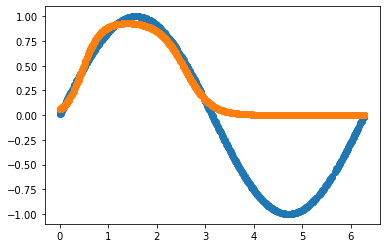

In [5]:
if __name__=='__main__':
    import matplotlib.pyplot as plt
    nn = NeuralNetwork([1, 100, 1],activations=['sigmoid', 'sigmoid'])
    X = 2*np.pi*np.random.rand(1000).reshape(1, -1)
    y = np.sin(X)
    
    nn.train(X, y, epochs=10000, batch_size=64, lr = .1)
    _, a_s = nn.feedforward(X)
    #print(y, X)
    plt.scatter(X.flatten(), y.flatten())
    plt.scatter(X.flatten(), a_s[-1].flatten())
    plt.show()